# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
def histogram(
        samples,
        kde=False,
        n_percentiles=None,
        parameter_names=None,
        ref_parameters=None,
        sample_names=None):
    """
    Takes one or more markov chains or lists of samples as input and creates
    and returns a plot showing histograms for each chain or list of samples.
    Returns a ``matplotlib`` figure object and axes handle.
    Parameters
    ----------
    samples
        A list of lists of samples, with shape
        ``(n_lists, n_samples, n_parameters)``, where ``n_lists`` is the
        number of lists of samples, ``n_samples`` is the number of samples in
        one list and ``n_parameters`` is the number of parameters.
    kde
        Set to ``True`` to include kernel-density estimation for the
        histograms.
    n_percentiles
        Shows only the middle n-th percentiles of the distribution.
        Default shows all samples in ``samples``.
    parameter_names
        A list of parameter names, which will be displayed on the x-axis of the
        histogram subplots. If no names are provided, the parameters are
        enumerated.
    ref_parameters
        A set of parameters for reference in the plot. For example, if true
        values of parameters are known, they can be passed in for plotting.
    """
    import matplotlib
    import matplotlib.pyplot as plt

    # Check matplotlib version
    use_old_matplotlib = False

    # If we switch to Python3 exclusively, bins and alpha can be keyword-only
    # arguments
    bins = 40
    alpha = 0.5
    n_list = len(samples)
    _, n_param = samples[0].shape

    # Check parameter names
    if parameter_names is None:
        parameter_names = ['Parameter' + str(i + 1) for i in range(n_param)]
    elif len(parameter_names) != n_param:
        raise ValueError(
            'Length of `parameter_names` must be same as number of'
            ' parameters.')

    # Check number of parameters
    for samples_j in samples:
        if n_param != samples_j.shape[1]:
            raise ValueError(
                'All samples must have the same number of parameters.'
            )

    # Check reference parameters
    if ref_parameters is not None:
        if len(ref_parameters) != n_param:
            raise ValueError(
                'Length of `ref_parameters` must be same as number of'
                ' parameters.')

    # Set up figure
    fig, axes = plt.subplots(
        n_param, 1, figsize=(6, 2 * n_param),
        squeeze=False,    # Tell matlab to always return a 2d axes object
    )

    # Plot first samples
    for i in range(n_param):
        for j_list, samples_j in enumerate(samples):
            # Add histogram subplot
            axes[i, 0].set_xlabel(parameter_names[i])
            axes[i, 0].set_ylabel('Frequency')
            if n_percentiles is None:
                xmin = np.min(samples_j[:, i])
                xmax = np.max(samples_j[:, i])
            else:
                xmin = np.percentile(samples_j[:, i],
                                     50 - n_percentiles / 2.)
                xmax = np.percentile(samples_j[:, i],
                                     50 + n_percentiles / 2.)
            xbins = np.linspace(xmin, xmax, bins)
            if sample_names is not None:
                label=sample_names[j_list]
            else:
                label='Samples ' + str(1 + j_list)
            if use_old_matplotlib:  # pragma: no cover
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, normed=True,
                    label=label)
            else:
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, density=True,
                    label=label)

            # Add kde plot
            if kde:
                x = np.linspace(xmin, xmax, 100)
                axes[i, 0].plot(x, stats.gaussian_kde(samples_j[:, i])(x))

        # Add reference parameters if given
        if ref_parameters is not None:
            # For histogram subplot
            ymin_tv, ymax_tv = axes[i, 0].get_ylim()
            axes[i, 0].plot(
                [ref_parameters[i], ref_parameters[i]],
                [0.0, ymax_tv],
                '--', c='k')
    if n_list > 1:
        axes[0, 0].legend()

    plt.tight_layout()
    return fig, axes[:, 0]

In [3]:
def surface(
        x_grid, y_grid, z_grid,
        cmap="Blues", angle=(25, 300), alpha=1.,
        fontsize=14, labelpad=10,
        title="", x_label="", y_label="", z_label="log_likelihood"):
    """
    Creates 3d contour plot given a grid for each axis.
    Arguments:
    ``x_grid``
        An NxN grid of values.
    ``y_grid``
        An NxN grid of values.
    ``z_grid``
        An NxN grid of values. z_grid determines colour.
    ``cmap``
        (Optional) Colour map used in the plot
    ``angle``
        (Optional) tuple specifying the viewing angle of the graph
    ``alpha``
        (Optional) alpha parameter of the surface
    ``fill``
        (Optional) Used to specify whether or not contour plot should be filled
        Default False.
    ``fontsize``
        (Optional) the fontsize used for labels
    ``labelpad``
        (Optional) distance of axis labels from the labels
    ``x_label``
        (Optional) The label of the x-axis
    ``y_label``
        (Optional) The label of the y-axis
    ``z_label``
        (Optional) The label of the z-axis
    Returns a ``matplotlib`` figure object and axes handle.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    ax = plt.axes(projection='3d')
    # Data for a three-dimensional line
    ax.plot_surface(x_grid, y_grid, z_grid, cmap=cmap, alpha=alpha)
    ax.view_init(*angle)

    fontsize = fontsize
    labelpad = labelpad

    if title:
        plt.title(title, fontsize=fontsize)
    if x_label:
        ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
    if y_label:
        ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
    if z_label:
        ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

    return ax

Next, I create a model class using the "Logistic" toy model included in pints:

In [4]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [5]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [6]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [7]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [8]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

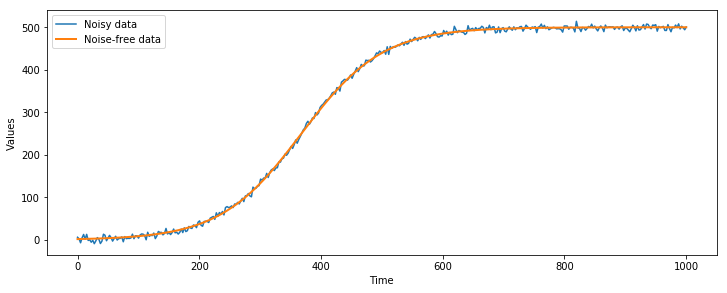

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [10]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [11]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

The resulting noise has mean zero and an unknown standard deviation. The standard deviation can be inferred along with the other parameters, meaning the number of parameters of the problem increased by one!

In [12]:
print('Original number of parameters: ' + str(problem.n_parameters()))

Original number of parameters: 2


In [13]:
print('New number of parameters: ' + str(log_likelihood.n_parameters()))

New number of parameters: 2


This means the vector of true parameters has to be updated:

In [14]:
#true_parameters += [noise]
print(true_parameters)

[0.015, 500]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [15]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [16]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [17]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [18]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.0476    0         0.143      0:00.0
40    123    0.0244    0.0732    0.0976     0:00.0
60    183    0.0328    0.0492    0.0656     0:00.1
80    243    0.0247    0.037     0.0494     0:00.1
100   303    0.0198    0.0594    0.0396     0:00.1
120   363    0.0165    0.0496    0.0331     0:00.1
140   423    0.0213    0.0426    0.0284     0:00.1
160   483    0.0186    0.0373    0.0248     0:00.1
180   543    0.0166    0.0331    0.0221     0:00.1
Initial phase completed.
200   603    0.0149    0.0299    0.0199     0:00.1
220   663    0.0181    0.0407    0.0271     0:00.1
240   723    0.0415    0.0581    0.0539     0:00.2
260   783   

3240  9723   0.252     0.244     0.251      0:02.4
3260  9783   0.252     0.244     0.252      0:02.4
3280  9843   0.253     0.243     0.252      0:02.4
3300  9903   0.254     0.243     0.252      0:02.4
3320  9963   0.254     0.242698  0.252      0:02.4
3340  10023  0.256     0.243     0.252619   0:02.4
3360  10083  0.255     0.243     0.252      0:02.4
3380  10143  0.254     0.243     0.251      0:02.5
3400  10203  0.254925  0.243     0.252      0:02.5
3420  10263  0.254     0.243     0.252      0:02.5
3440  10323  0.254     0.243     0.251671   0:02.5
3460  10383  0.253395  0.243     0.252      0:02.5
3480  10443  0.253     0.243     0.252      0:02.5
3500  10503  0.252     0.244     0.251928   0:02.5
3520  10563  0.252     0.244     0.250781   0:02.6
3540  10623  0.251     0.244     0.25       0:02.6
3560  10683  0.251     0.244     0.25       0:02.6
3580  10743  0.251     0.244     0.251      0:02.6
3600  10803  0.251     0.245     0.251      0:02.6
3620  10863  0.25      0.244   

6560  19683  0.243     0.23975   0.239      0:04.8
6580  19743  0.243     0.24      0.239      0:04.8
6600  19803  0.243     0.239     0.239      0:04.8
6620  19863  0.242     0.238     0.238      0:04.8
6640  19923  0.242     0.238     0.239      0:04.8
6660  19983  0.243     0.238     0.238      0:04.9
6680  20043  0.243     0.238587  0.238      0:04.9
6700  20103  0.242     0.238     0.238      0:04.9
6720  20163  0.243     0.239     0.239      0:04.9
6740  20223  0.242     0.238     0.239      0:04.9
6760  20283  0.242     0.238     0.23887    0:04.9
6780  20343  0.242     0.238     0.238      0:04.9
6800  20403  0.242     0.238     0.238      0:05.0
6820  20463  0.242     0.238     0.238      0:05.0
6840  20523  0.242     0.238     0.238      0:05.0
6860  20583  0.242     0.238012  0.238      0:05.0
6880  20643  0.241     0.238     0.238      0:05.0
6900  20703  0.241     0.238     0.238      0:05.0
6920  20763  0.241     0.238     0.239      0:05.0
6940  20823  0.241     0.238   

9920  29763  0.24      0.239996  0.239      0:07.2
9940  29823  0.239     0.24      0.239      0:07.2
9960  29883  0.239     0.24      0.239      0:07.3
9980  29943  0.239     0.24      0.239      0:07.3
10000 30000  0.2394    0.2396    0.2389     0:07.3
Halting: Maximum number of iterations (10000) reached.


## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

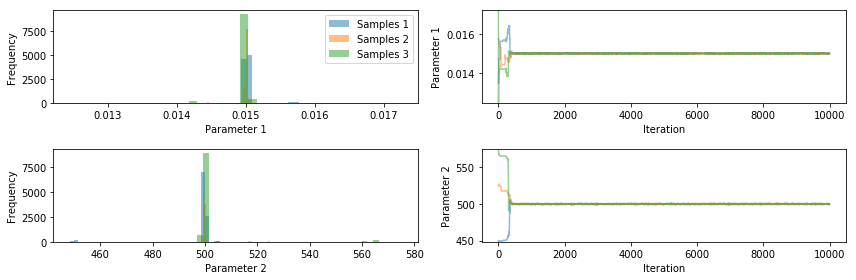

In [19]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [20]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

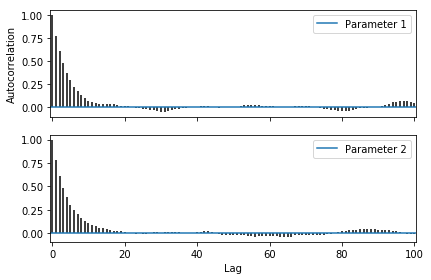

In [21]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

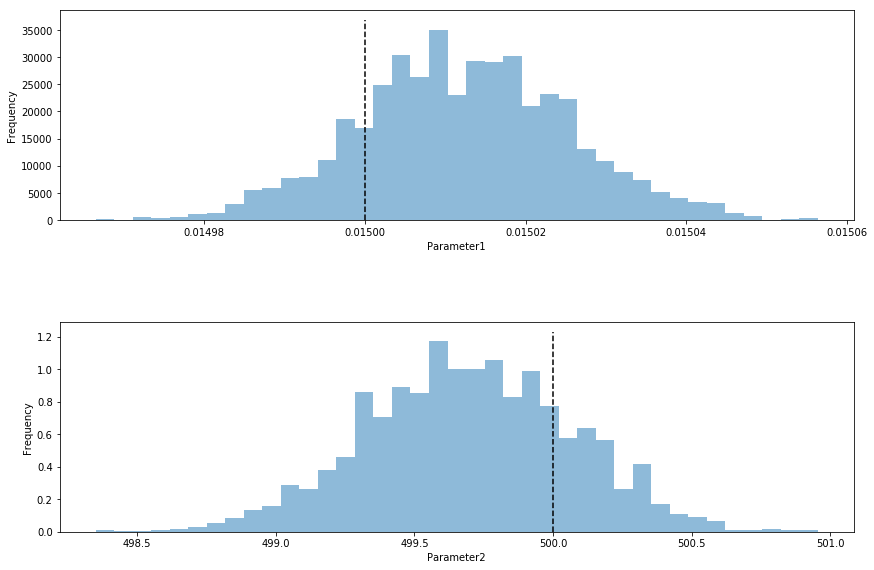

In [22]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [23]:
thinned_chain = chain[::10]

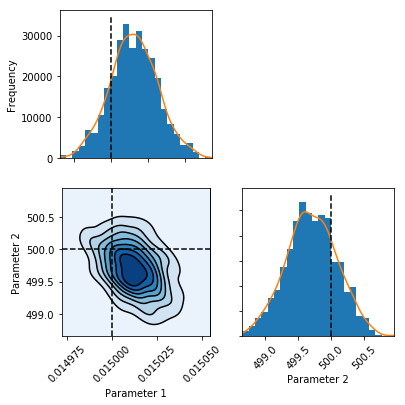

In [24]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

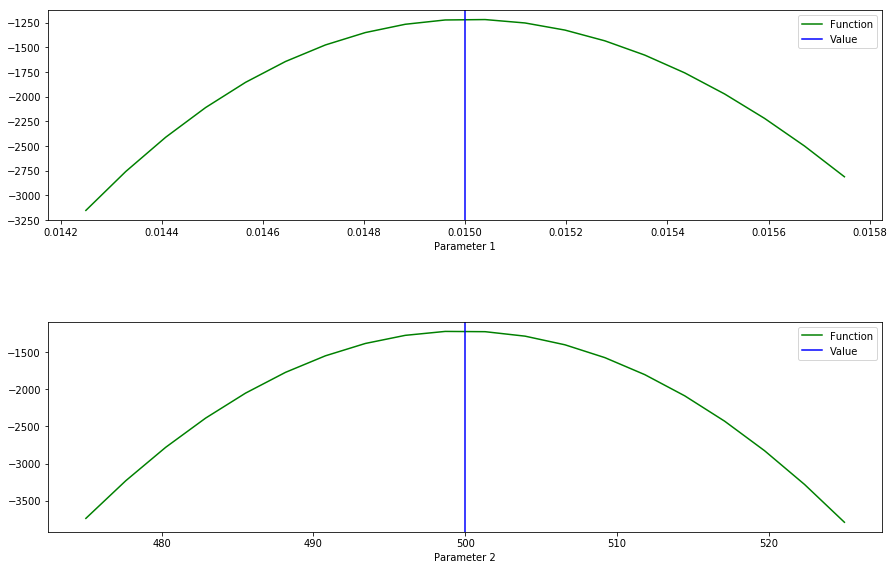

In [25]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

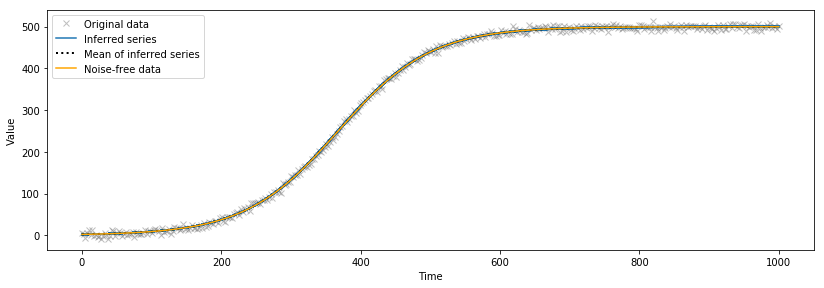

In [26]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1215.006951554928
[1.50138386e-02 5.00289193e+02]
-1214.0502396351121


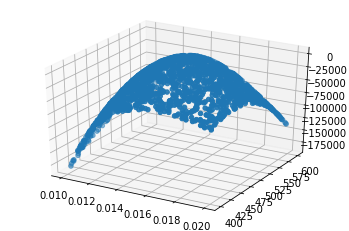

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [28]:
print(input_parameters[:5])

[[1.37604021e-02 4.10854527e+02]
 [1.37618104e-02 4.94751547e+02]
 [1.50444346e-02 5.26975554e+02]
 [1.21744397e-02 4.34668091e+02]
 [1.78746777e-02 5.66529787e+02]]


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [30]:
emu([0.015, 500])

array([[-1347.377]], dtype=float32)

In [31]:
log_likelihood([0.015, 500])

-1214.0502396351121

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


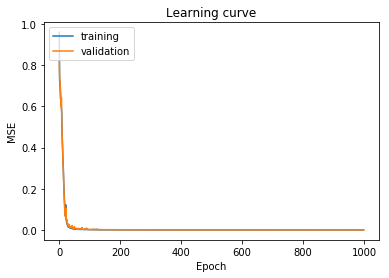

In [32]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


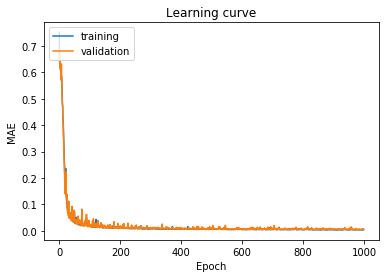

In [33]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

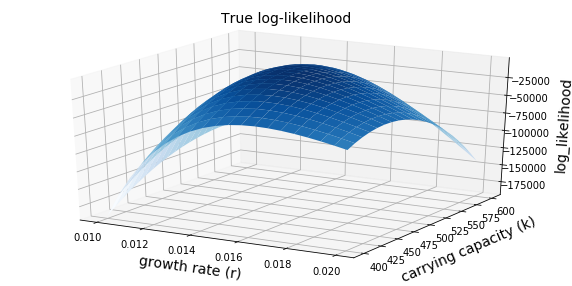

In [34]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

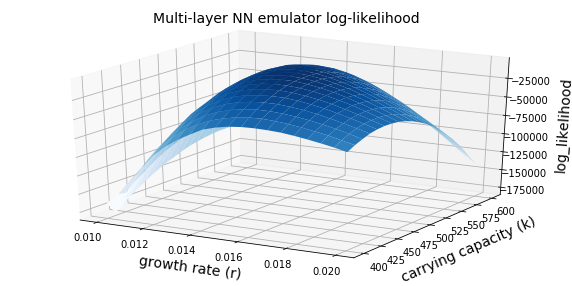

In [35]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

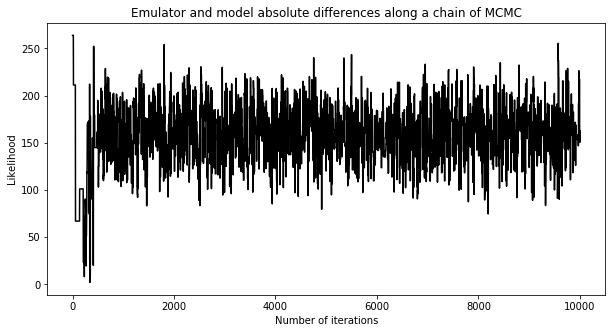

162.91638455818747

In [36]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [37]:
print(emu_prediction)

[-24444.186  -24444.186  -24444.186  ...  -1374.3105  -1364.752
  -1376.8223]


In [38]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [39]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0.25      0          0:00.0
20    63     0.0952    0.0952    0.0952     0:00.0
40    123    0.0732    0.0488    0.0976     0:00.1
60    183    0.0492    0.0492    0.0656     0:00.1
80    243    0.0494    0.037     0.0494     0:00.1
100   303    0.0495    0.0396    0.0396     0:00.1
120   363    0.0413    0.0413    0.0331     0:00.2
140   423    0.0355    0.0355    0.0284     0:00.2
160   483    0.0311    0.0373    0.0248     0:00.2
180   543    0.0276    0.0331    0.0276     0:00.2
Initial phase completed.
200   603    0.0299    0.0348    0.0299     0:00.3
220   663    0.0271    0.0362    0.0452     0:00.3
240   723    0.0373    0.0373    0.0664     0:00.4
260   783   

3140  9423   0.285     0.254696  0.258      0:08.5
3160  9483   0.286     0.256248  0.257      0:08.6
3180  9543   0.285     0.257     0.257      0:08.7
3200  9603   0.287     0.257     0.256      0:08.7
3220  9663   0.287     0.257     0.258      0:08.8
3240  9723   0.287257  0.257     0.257      0:08.8
3260  9783   0.286     0.256     0.257283   0:08.9
3280  9843   0.286     0.255     0.258      0:08.9
3300  9903   0.285     0.256     0.258      0:09.0
3320  9963   0.284     0.255     0.257      0:09.0
3340  10023  0.285     0.255     0.257408   0:09.1
3360  10083  0.284     0.254     0.256      0:09.1
3380  10143  0.284     0.255     0.256      0:09.2
3400  10203  0.284     0.254925  0.254631   0:09.3
3420  10263  0.284     0.254     0.255      0:09.3
3440  10323  0.283     0.255     0.256      0:09.4
3460  10383  0.283     0.254     0.256      0:09.4
3480  10443  0.283     0.253     0.255      0:09.5
3500  10503  0.284     0.252     0.253      0:09.5
3520  10563  0.283     0.253   

6420  19263  0.26      0.245     0.239      0:17.6
6440  19323  0.26      0.245     0.239      0:17.7
6460  19383  0.26      0.245     0.238508   0:17.7
6480  19443  0.26      0.246     0.238      0:17.8
6500  19503  0.259     0.246     0.238      0:17.8
6520  19563  0.258     0.245     0.238307   0:17.9
6540  19623  0.258     0.245     0.238      0:17.9
6560  19683  0.259     0.244     0.238      0:18.0
6580  19743  0.259     0.245     0.238      0:18.1
6600  19803  0.259     0.245     0.238      0:18.1
6620  19863  0.259     0.245     0.238      0:18.2
6640  19923  0.259     0.246     0.238      0:18.2
6660  19983  0.259     0.245     0.238      0:18.3
6680  20043  0.259     0.246     0.238      0:18.3
6700  20103  0.259     0.246     0.237278   0:18.4
6720  20163  0.259     0.247     0.237      0:18.4
6740  20223  0.259     0.247441  0.237      0:18.5
6760  20283  0.259577  0.248     0.237      0:18.6
6780  20343  0.26      0.248     0.236      0:18.6
6800  20403  0.259     0.247   

9700  29103  0.25      0.238429  0.241      0:26.7
9720  29163  0.251     0.238     0.241      0:26.7
9740  29223  0.25      0.238     0.241043   0:26.8
9760  29283  0.25      0.239     0.242      0:26.8
9780  29343  0.251     0.239     0.242      0:26.9
9800  29403  0.251     0.239     0.241      0:26.9
9820  29463  0.251     0.239     0.242      0:27.0
9840  29523  0.251     0.239     0.242      0:27.0
9860  29583  0.251     0.239     0.242      0:27.1
9880  29643  0.251     0.239     0.241      0:27.1
9900  29703  0.251     0.239     0.241      0:27.2
9920  29763  0.251     0.239     0.241      0:27.3
9940  29823  0.252     0.239     0.241      0:27.3
9960  29883  0.252     0.24      0.241      0:27.4
9980  29943  0.251     0.24      0.241559   0:27.4
10000 30000  0.2515    0.2396    0.2416     0:27.5
Halting: Maximum number of iterations (10000) reached.


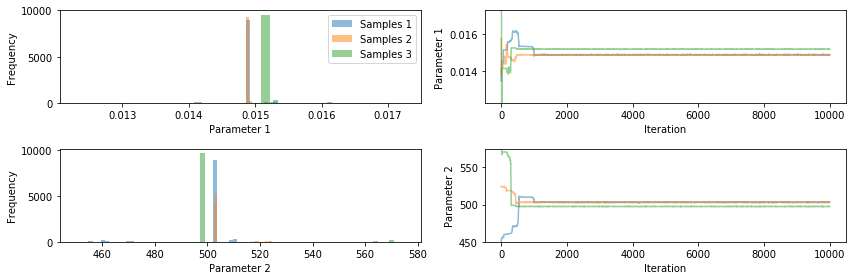

In [40]:
pints.plot.trace(chains_emu)
plt.show()

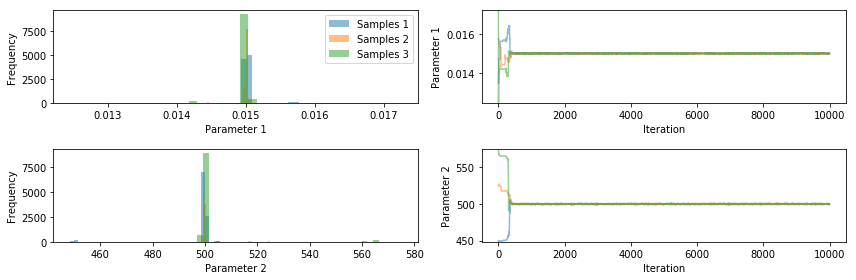

In [41]:
pints.plot.trace(chains)
plt.show()

In [42]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

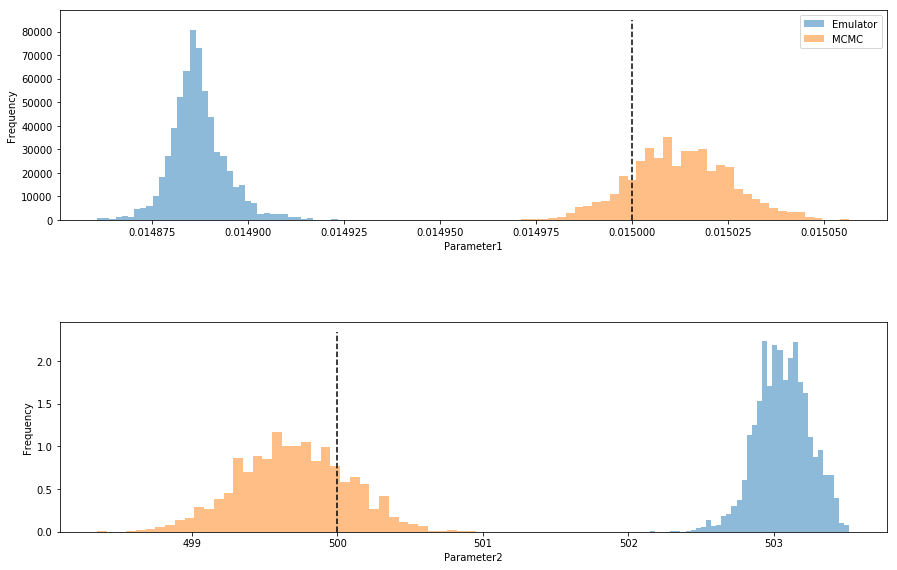

In [43]:
fig, axes = histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

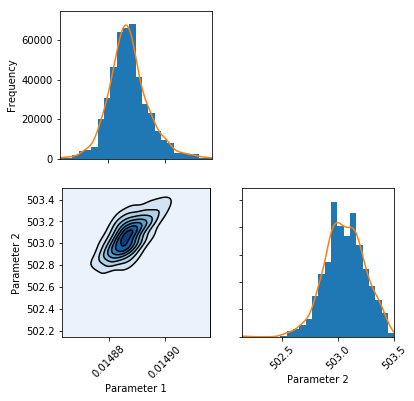

In [44]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

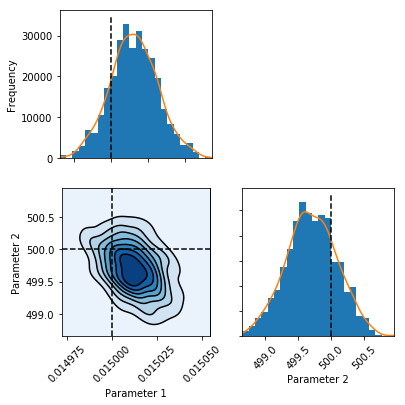

In [45]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

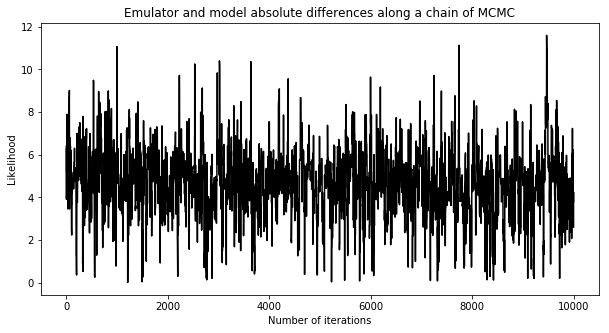

2.610959191812526

In [46]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [47]:
chain_emu

array([[1.48908387e-02, 5.03123854e+02],
       [1.48995637e-02, 5.03171680e+02],
       [1.49113580e-02, 5.03465945e+02],
       ...,
       [1.48983825e-02, 5.03308602e+02],
       [1.48983825e-02, 5.03308602e+02],
       [1.48965074e-02, 5.03426174e+02]])

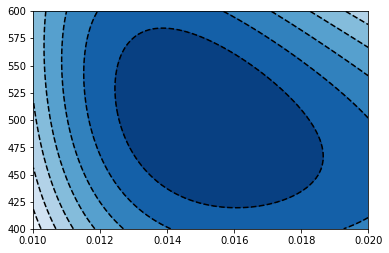

In [48]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

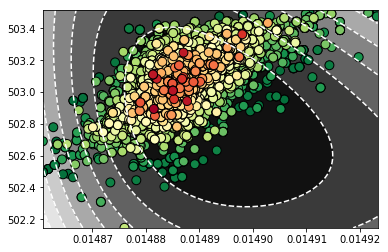

In [49]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.667     0         0          0:00.0
3     12     0.5       0         0.25       0:00.0
20    63     0.0952    0.0952    0.143      0:00.0
40    123    0.0488    0.0488    0.0732     0:00.1
60    183    0.0328    0.0328    0.0656     0:00.1
80    243    0.0247    0.0247    0.0494     0:00.1
100   303    0.0198    0.0198    0.0495     0:00.1
120   363    0.0165    0.0165    0.0496     0:00.1
140   423    0.0142    0.0142    0.0426     0:00.1
160   483    0.0124    0.0186    0.0373     0:00.2
180   543    0.011     0.0166    0.0442     0:00.2
200   603    0.00995   0.0149    0.039801   0:00.2
220   663    0.00905   0.0136    0.0362     0:00.2
240   723    0.0083    0.0166    0.0332     0:00.2
260   783    0.00766   0.0153    0.0307   

3160  9483   0.0149    0.00949   0.0168     0:02.6
3180  9543   0.0151    0.00943   0.0167     0:02.6
3200  9603   0.0153    0.00937   0.0169     0:02.7
3220  9663   0.0152    0.00931   0.0168     0:02.7
3240  9723   0.0151    0.00926   0.0167     0:02.7
3260  9783   0.015     0.0092    0.0166     0:02.7
3280  9843   0.0152    0.00975   0.0168     0:02.7
3300  9903   0.0151    0.00969   0.0167     0:02.7
3320  9963   0.0151    0.00964   0.0166     0:02.8
3340  10023  0.015     0.00958   0.0165     0:02.8
3360  10083  0.0149    0.00952   0.0164     0:02.8
3380  10143  0.0151    0.00946   0.0163     0:02.8
3400  10203  0.015     0.00941   0.0162     0:02.8
3420  10263  0.0152    0.00935   0.0161     0:02.8
3440  10323  0.0154    0.00959   0.0163     0:02.9
3460  10383  0.0153    0.00953   0.0168     0:02.9
3480  10443  0.0155    0.00948   0.0167     0:02.9
3500  10503  0.016     0.00943   0.0166     0:02.9
3520  10563  0.0159    0.00937   0.0165     0:02.9
3540  10623  0.0158    0.00932 

6560  19683  0.0122    0.00838   0.0137     0:05.2
6580  19743  0.0122    0.00836   0.0137     0:05.3
6600  19803  0.0121    0.00833   0.0139     0:05.3
6620  19863  0.0121    0.00831   0.0139     0:05.3
6640  19923  0.012     0.00828   0.014      0:05.3
6660  19983  0.0122    0.00826   0.014      0:05.3
6680  20043  0.0123    0.00823   0.0141     0:05.3
6700  20103  0.0122    0.00821   0.0142     0:05.3
6720  20163  0.0122    0.00833   0.0141     0:05.4
6740  20223  0.0123    0.00831   0.0141     0:05.4
6760  20283  0.0123    0.00828   0.0142     0:05.4
6780  20343  0.0122    0.00826   0.0142     0:05.4
6800  20403  0.0122    0.00823   0.0141     0:05.4
6820  20463  0.0122    0.00821   0.0141     0:05.4
6840  20523  0.0121    0.00819   0.014      0:05.5
6860  20583  0.0121    0.00816   0.014      0:05.5
6880  20643  0.0121    0.00814   0.014      0:05.5
6900  20703  0.012     0.00811   0.0139     0:05.5
6920  20763  0.012     0.00809   0.0139     0:05.5
6940  20823  0.012     0.00807 

10000 30003  0.0101    0.0065    0.013      0:07.8
10020 30063  0.0101    0.00649   0.0131     0:07.8
10040 30123  0.0101    0.00647   0.013      0:07.8
10060 30183  0.01      0.00646   0.013      0:07.9
10080 30243  0.01      0.00645   0.013      0:07.9
10100 30303  0.01      0.00644   0.013      0:07.9
10120 30363  0.00998   0.00642   0.0129     0:07.9
10140 30423  0.00996   0.00651   0.0129     0:07.9
10160 30483  0.00994   0.0065    0.0129     0:07.9
10180 30543  0.0101    0.00648   0.013      0:07.9
10200 30603  0.0101    0.00647   0.0129     0:08.0
10220 30663  0.0101    0.00646   0.0129     0:08.0
10240 30723  0.0101    0.00644   0.013      0:08.0
10260 30783  0.0101    0.00643   0.013      0:08.0
10280 30843  0.0101    0.00642   0.0129     0:08.0
10300 30903  0.0101    0.00641   0.013      0:08.0
10320 30963  0.0101    0.00639   0.013      0:08.0
10340 31023  0.0101    0.00638   0.013      0:08.1
10360 31083  0.01      0.00637   0.0129     0:08.1
10380 31143  0.01      0.00636 

13260 39783  0.00928   0.00535   0.0118     0:10.2
13280 39843  0.00926   0.00535   0.0117     0:10.2
13300 39903  0.00925   0.00534   0.0117     0:10.2
13320 39963  0.00923   0.00533   0.0117     0:10.2
13340 40023  0.00922   0.00532   0.0117     0:10.2
13360 40083  0.00921   0.00531   0.0117     0:10.2
13380 40143  0.00919   0.00531   0.0117     0:10.2
13400 40203  0.00918   0.0053    0.0117     0:10.3
13420 40263  0.00916   0.00529   0.0117     0:10.3
13440 40323  0.00915   0.00528   0.0117     0:10.3
13460 40383  0.00914   0.00527   0.0117     0:10.3
13480 40443  0.00912   0.00527   0.0117     0:10.3
13500 40503  0.00911   0.00526   0.0117     0:10.3
13520 40563  0.0091    0.00525   0.0117     0:10.3
13540 40623  0.00908   0.00524   0.0117     0:10.4
13560 40683  0.00907   0.00524   0.0117     0:10.4
13580 40743  0.00906   0.00523   0.0116     0:10.4
13600 40803  0.00904   0.00522   0.0116     0:10.4
13620 40863  0.00903   0.00521   0.0116     0:10.4
13640 40923  0.00902   0.0052  

16700 50103  0.00778   0.00449   0.0105     0:12.5
16720 50163  0.00783   0.00449   0.0105     0:12.6
16740 50223  0.00783   0.00448   0.0105     0:12.6
16760 50283  0.00782   0.00447   0.0106     0:12.6
16780 50343  0.00781   0.00447   0.0105     0:12.6
16800 50403  0.0078    0.00446   0.0105     0:12.6
16820 50463  0.00779   0.00446   0.0105     0:12.6
16840 50523  0.00778   0.00445   0.0105     0:12.6
16860 50583  0.00777   0.00445   0.0105     0:12.7
16880 50643  0.00776   0.00444   0.0105     0:12.7
16900 50703  0.00775   0.00444   0.0105     0:12.7
16920 50763  0.00774   0.00443   0.0105     0:12.7
16940 50823  0.00773   0.00443   0.0104     0:12.7
16960 50883  0.00772   0.00448   0.0104     0:12.7
16980 50943  0.00771   0.00448   0.0104     0:12.7
17000 51003  0.00771   0.00447   0.0104     0:12.8
17020 51063  0.0077    0.00447   0.0104     0:12.8
17040 51123  0.00769   0.00446   0.0104     0:12.8
17060 51183  0.00768   0.00445   0.0104     0:12.8
17080 51243  0.00767   0.00445 

20200 60603  0.00678   0.00391   0.00941    0:14.9
20220 60663  0.00678   0.00391   0.0094     0:14.9
20240 60723  0.00677   0.0039    0.00939    0:15.0
20260 60783  0.00676   0.0039    0.00938    0:15.0
20280 60843  0.00676   0.0039    0.00937    0:15.0
20300 60903  0.00675   0.00389   0.00936    0:15.0
20320 60963  0.00674   0.00389   0.00935    0:15.0
20340 61023  0.00674   0.00388   0.00934    0:15.0
20360 61083  0.00673   0.00388   0.00933    0:15.0
20380 61143  0.00672   0.00388   0.00932    0:15.0
20400 61203  0.00672   0.00387   0.00931    0:15.1
20420 61263  0.00671   0.00387   0.0093     0:15.1
20440 61323  0.0067    0.00386   0.0093     0:15.1
20460 61383  0.0067    0.00386   0.00929    0:15.1
20480 61443  0.00669   0.00391   0.00928    0:15.1
20500 61503  0.00668   0.0039    0.00927    0:15.1
20520 61563  0.00668   0.0039    0.00926    0:15.1
20540 61623  0.00667   0.00389   0.00925    0:15.2
20560 61683  0.00666   0.00389   0.00924    0:15.2
20580 61743  0.00666   0.00389 

23440 70323  0.0061    0.00358   0.00823    0:17.1
23460 70383  0.0061    0.00358   0.00823    0:17.1
23480 70443  0.00609   0.00358   0.00822    0:17.1
23500 70503  0.00608   0.00357   0.00821    0:17.1
23520 70563  0.00608   0.00357   0.00821    0:17.1
23540 70623  0.00607   0.00357   0.0082     0:17.2
23560 70683  0.00607   0.00357   0.00819    0:17.2
23580 70743  0.00606   0.00356   0.00818    0:17.2
23600 70803  0.00606   0.00356   0.00818    0:17.2
23620 70863  0.00605   0.00356   0.00817    0:17.2
23640 70923  0.00605   0.00355   0.00816    0:17.2
23660 70983  0.00604   0.00355   0.00816    0:17.2
23680 71043  0.00604   0.00355   0.00815    0:17.2
23700 71103  0.00603   0.00354   0.00814    0:17.3
23720 71163  0.00603   0.00354   0.00814    0:17.3
23740 71223  0.00602   0.00358   0.00813    0:17.3
23760 71283  0.00602   0.00358   0.00812    0:17.3
23780 71343  0.00601   0.00357   0.00812    0:17.3
23800 71403  0.00601   0.00357   0.00811    0:17.3
23820 71463  0.006     0.00357 

26680 80043  0.00551   0.00345   0.00738    0:19.3
26700 80103  0.00551   0.00345   0.00738    0:19.3
26720 80163  0.0055    0.00344   0.00737    0:19.3
26740 80223  0.0055    0.00344   0.00737    0:19.3
26760 80283  0.00549   0.00344   0.00736    0:19.3
26780 80343  0.00549   0.00344   0.00736    0:19.3
26800 80403  0.00548   0.00343   0.00735    0:19.3
26820 80463  0.00548   0.00343   0.00734    0:19.4
26840 80523  0.00548   0.00343   0.00734    0:19.4
26860 80583  0.00547   0.00343   0.00733    0:19.4
26880 80643  0.00547   0.00342   0.00733    0:19.4
26900 80703  0.00546   0.00346   0.00732    0:19.4
26920 80763  0.00546   0.00345   0.00732    0:19.4
26940 80823  0.00549   0.00345   0.00731    0:19.4
26960 80883  0.00549   0.00345   0.00731    0:19.5
26980 80943  0.00549   0.00345   0.00734    0:19.5
27000 81003  0.00548   0.00344   0.00733    0:19.5
27020 81063  0.00548   0.00344   0.00733    0:19.5
27040 81123  0.00547   0.00344   0.00736    0:19.5
27060 81183  0.00547   0.00344 

R-hat:
[1.7981380967821505, 1.899646779800949]


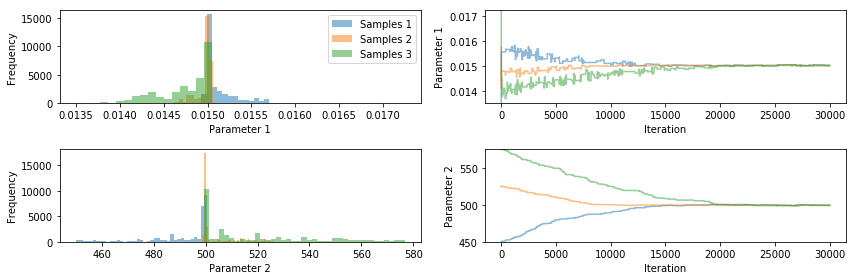

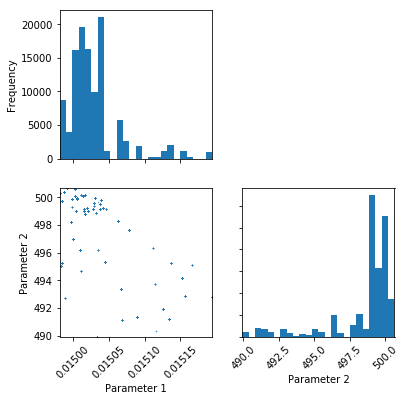

In [50]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=emu)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.333     0         0          0:00.0
3     12     0.25      0         0          0:00.0
20    63     0.0952    0.0952    0.0952     0:00.1
40    123    0.0488    0.0488    0.0976     0:00.1
60    183    0.0328    0.0328    0.0656     0:00.2
80    243    0.0247    0.0494    0.0494     0:00.2
100   303    0.0198    0.0495    0.0396     0:00.3
120   363    0.0248    0.0413    0.0413     0:00.3
140   423    0.0213    0.0355    0.0355     0:00.4
160   483    0.0186    0.0373    0.0311     0:00.4
180   543    0.0221    0.0331    0.0276     0:00.5
200   603    0.0199    0.0299    0.0249     0:00.5
220   663    0.0181    0.0271    0.0271     0:00.6
240   723    0.0166    0.0249    0.0249     0:00.6
260   783    0.0153    0.023     0.023    

3140  9423   0.0108    0.00923   0.00955    0:08.2
3160  9483   0.0108    0.00917   0.00949    0:08.3
3180  9543   0.011     0.00912   0.00943    0:08.3
3200  9603   0.0112    0.00906   0.00937    0:08.4
3220  9663   0.0112    0.009     0.00931    0:08.4
3240  9723   0.0111    0.00895   0.00926    0:08.5
3260  9783   0.011     0.00889   0.00951    0:08.5
3280  9843   0.011     0.00884   0.00945    0:08.6
3300  9903   0.0109    0.00879   0.00939    0:08.6
3320  9963   0.0108    0.00873   0.00933    0:08.7
3340  10023  0.0108    0.00868   0.00958    0:08.7
3360  10083  0.0107    0.00863   0.00952    0:08.8
3380  10143  0.0106    0.00858   0.00946    0:08.8
3400  10203  0.0106    0.00853   0.00941    0:08.9
3420  10263  0.0108    0.00848   0.00994    0:09.0
3440  10323  0.0108    0.00843   0.00988    0:09.0
3460  10383  0.0107    0.00867   0.00982    0:09.1
3480  10443  0.0106    0.00862   0.00977    0:09.1
3500  10503  0.0109    0.00857   0.00971    0:09.2
3520  10563  0.0111    0.00852 

6360  19083  0.00959   0.00645   0.0088     0:16.8
6380  19143  0.00956   0.00643   0.00878    0:16.8
6400  19203  0.00953   0.00641   0.00875    0:16.9
6420  19263  0.0095    0.00639   0.00872    0:16.9
6440  19323  0.00947   0.00637   0.00869    0:17.0
6460  19383  0.00944   0.00635   0.00882    0:17.1
6480  19443  0.00941   0.00633   0.00879    0:17.1
6500  19503  0.00938   0.00631   0.00877    0:17.2
6520  19563  0.00935   0.00629   0.00874    0:17.2
6540  19623  0.00933   0.00642   0.00871    0:17.3
6560  19683  0.0093    0.00655   0.00869    0:17.3
6580  19743  0.00927   0.00653   0.00866    0:17.4
6600  19803  0.00924   0.00651   0.00864    0:17.4
6620  19863  0.00921   0.00649   0.00861    0:17.5
6640  19923  0.00919   0.00647   0.00858    0:17.5
6660  19983  0.00916   0.00661   0.00856    0:17.6
6680  20043  0.00913   0.00674   0.00853    0:17.6
6700  20103  0.0091    0.00672   0.00851    0:17.7
6720  20163  0.00908   0.0067    0.00848    0:17.7
6740  20223  0.0092    0.00668 

9640  28923  0.00882   0.00529   0.00851    0:25.3
9660  28983  0.0088    0.00528   0.00849    0:25.3
9680  29043  0.00888   0.00527   0.00847    0:25.4
9700  29103  0.00887   0.00526   0.00856    0:25.5
9720  29163  0.00885   0.00525   0.00854    0:25.5
9740  29223  0.00883   0.00544   0.00873    0:25.6
9760  29283  0.00881   0.00543   0.00891    0:25.6
9780  29343  0.00889   0.00542   0.00889    0:25.7
9800  29403  0.00888   0.00541   0.00888    0:25.7
9820  29463  0.00896   0.0054    0.00886    0:25.8
9840  29523  0.00894   0.00539   0.00894    0:25.8
9860  29583  0.00892   0.00537   0.00892    0:25.9
9880  29643  0.00891   0.00536   0.00901    0:25.9
9900  29703  0.00899   0.00535   0.00899    0:26.0
9920  29763  0.00897   0.00534   0.00897    0:26.0
9940  29823  0.00895   0.00533   0.00905    0:26.1
9960  29883  0.00893   0.00532   0.00904    0:26.1
9980  29943  0.00892   0.00541   0.00902    0:26.2
10000 30003  0.0089    0.0054    0.009      0:26.2
10020 30063  0.00888   0.00539 

12920 38763  0.00743   0.00441   0.00998    0:33.8
12940 38823  0.00742   0.0044    0.00997    0:33.9
12960 38883  0.00741   0.0044    0.00995    0:33.9
12980 38943  0.00747   0.00439   0.00994    0:34.0
13000 39003  0.00746   0.00438   0.00992    0:34.0
13020 39063  0.00745   0.00438   0.00991    0:34.1
13040 39123  0.00744   0.00437   0.00997    0:34.1
13060 39183  0.00743   0.00436   0.00995    0:34.2
13080 39243  0.00742   0.00436   0.00994    0:34.2
13100 39303  0.0074    0.00435   0.01       0:34.3
13120 39363  0.00739   0.00434   0.00998    0:34.3
13140 39423  0.00738   0.00434   0.00997    0:34.4
13160 39483  0.00737   0.00433   0.00995    0:34.4
13180 39543  0.00736   0.00432   0.00994    0:34.5
13200 39603  0.00735   0.00432   0.00992    0:34.5
13220 39663  0.00734   0.00431   0.00991    0:34.6
13240 39723  0.00733   0.0043    0.00989    0:34.6
13260 39783  0.00731   0.0043    0.00988    0:34.7
13280 39843  0.0073    0.00429   0.00994    0:34.7
13300 39903  0.00729   0.00429 

16200 48603  0.00642   0.00358   0.00907    0:42.3
16220 48663  0.00641   0.00358   0.00906    0:42.3
16240 48723  0.0064    0.00357   0.00905    0:42.4
16260 48783  0.0064    0.00357   0.00904    0:42.4
16280 48843  0.00639   0.00356   0.00903    0:42.5
16300 48903  0.00638   0.00356   0.00902    0:42.5
16320 48963  0.00637   0.00355   0.00901    0:42.6
16340 49023  0.00636   0.00355   0.009      0:42.6
16360 49083  0.00636   0.00355   0.00898    0:42.7
16380 49143  0.00635   0.00354   0.00897    0:42.7
16400 49203  0.00634   0.00354   0.00902    0:42.8
16420 49263  0.00633   0.00353   0.00901    0:42.8
16440 49323  0.00633   0.00353   0.009      0:42.9
16460 49383  0.00632   0.00352   0.00899    0:42.9
16480 49443  0.00631   0.00352   0.00898    0:43.0
16500 49503  0.0063    0.00351   0.00897    0:43.0
16520 49563  0.0063    0.00351   0.00896    0:43.1
16540 49623  0.00629   0.00351   0.00895    0:43.1
16560 49683  0.00628   0.0035    0.00894    0:43.2
16580 49743  0.00627   0.0035  

19460 58383  0.00581   0.00303   0.0076     0:50.7
19480 58443  0.00585   0.00303   0.0076     0:50.7
19500 58503  0.00585   0.00303   0.00759    0:50.8
19520 58563  0.00584   0.00302   0.00758    0:50.8
19540 58623  0.00583   0.00302   0.00757    0:50.9
19560 58683  0.00583   0.00302   0.00757    0:50.9
19580 58743  0.00582   0.00301   0.00756    0:51.0
19600 58803  0.00587   0.00301   0.00755    0:51.0
19620 58863  0.00586   0.00301   0.00754    0:51.1
19640 58923  0.00586   0.003     0.00754    0:51.1
19660 58983  0.00585   0.003     0.00753    0:51.2
19680 59043  0.00584   0.003     0.00752    0:51.2
19700 59103  0.00584   0.00299   0.00751    0:51.3
19720 59163  0.00583   0.00299   0.0075     0:51.3
19740 59223  0.00583   0.00299   0.0075     0:51.4
19760 59283  0.00582   0.00299   0.00749    0:51.4
19780 59343  0.00581   0.00298   0.00748    0:51.5
19800 59403  0.00581   0.00298   0.00747    0:51.5
19820 59463  0.0058    0.00298   0.00747    0:51.6
19840 59523  0.0058    0.00297 

22720 68163  0.00533   0.00268   0.00651    0:59.1
22740 68223  0.00532   0.00268   0.00651    0:59.1
22760 68283  0.00532   0.00268   0.0065     0:59.2
22780 68343  0.00531   0.00268   0.0065     0:59.2
22800 68403  0.00531   0.00268   0.00649    0:59.3
22820 68463  0.0053    0.00267   0.00649    0:59.3
22840 68523  0.0053    0.00267   0.00648    0:59.4
22860 68583  0.00529   0.00267   0.00647    0:59.4
22880 68643  0.00529   0.00267   0.00647    0:59.5
22900 68703  0.00528   0.00266   0.00646    0:59.5
22920 68763  0.00528   0.00266   0.00646    0:59.6
22940 68823  0.00527   0.00266   0.00645    0:59.6
22960 68883  0.00527   0.00266   0.00645    0:59.7
22980 68943  0.00527   0.00265   0.00644    0:59.7
23000 69003  0.00526   0.00265   0.00643    0:59.8
23020 69063  0.00526   0.00265   0.00643    0:59.8
23040 69123  0.00525   0.00265   0.00642    0:59.9
23060 69183  0.00525   0.00265   0.00642    0:59.9
23080 69243  0.00524   0.00264   0.00641    1:00.0
23100 69303  0.00524   0.00264 

25960 77883  0.0047    0.00243   0.00578    1:07.4
25980 77943  0.0047    0.00242   0.00577    1:07.5
26000 78003  0.00469   0.00242   0.00577    1:07.5
26020 78063  0.00469   0.00242   0.00576    1:07.6
26040 78123  0.00468   0.00242   0.00576    1:07.6
26060 78183  0.00468   0.00242   0.00576    1:07.7
26080 78243  0.00468   0.00242   0.00575    1:07.7
26100 78303  0.00467   0.00241   0.00575    1:07.8
26120 78363  0.00467   0.00241   0.00578    1:07.8
26140 78423  0.00467   0.00241   0.00578    1:07.9
26160 78483  0.00466   0.00241   0.00577    1:07.9
26180 78543  0.00466   0.00241   0.00577    1:08.0
26200 78603  0.00466   0.0024    0.00576    1:08.0
26220 78663  0.00465   0.0024    0.00576    1:08.1
26240 78723  0.00465   0.0024    0.00575    1:08.1
26260 78783  0.00465   0.0024    0.00575    1:08.2
26280 78843  0.00464   0.0024    0.00575    1:08.2
26300 78903  0.00464   0.0024    0.00578    1:08.3
26320 78963  0.00464   0.00239   0.00577    1:08.3
26340 79023  0.00463   0.00239 

29260 87783  0.00417   0.00215   0.00564    1:15.9
29280 87843  0.00417   0.00215   0.00564    1:16.0
29300 87903  0.00416   0.00215   0.00563    1:16.0
29320 87963  0.00416   0.00215   0.00563    1:16.1
29340 88023  0.00416   0.00215   0.00562    1:16.1
29360 88083  0.00416   0.00215   0.00562    1:16.2
29380 88143  0.00415   0.00214   0.00562    1:16.2
29400 88203  0.00415   0.00214   0.00561    1:16.3
29420 88263  0.00415   0.00214   0.00561    1:16.4
29440 88323  0.00414   0.00214   0.0056     1:16.4
29460 88383  0.00414   0.00214   0.0056     1:16.5
29480 88443  0.00414   0.00214   0.0056     1:16.5
29500 88503  0.00414   0.00214   0.00559    1:16.6
29520 88563  0.00413   0.00213   0.00559    1:16.6
29540 88623  0.00413   0.00213   0.00559    1:16.7
29560 88683  0.00413   0.00213   0.00558    1:16.7
29580 88743  0.00412   0.00213   0.00558    1:16.8
29600 88803  0.00412   0.00213   0.00557    1:16.8
29620 88863  0.00412   0.00213   0.00557    1:16.9
29640 88923  0.00412   0.00213 

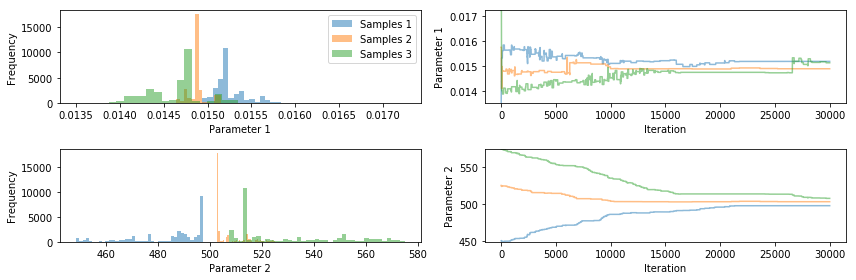

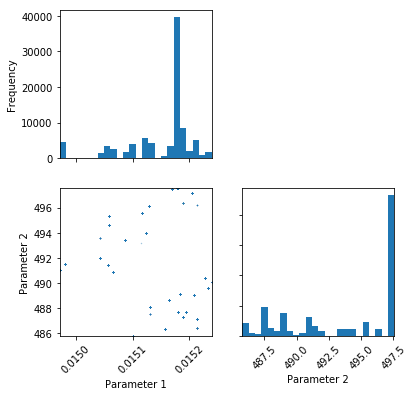

In [51]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0.5        0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.5       0.25      0.25       0:00.0
20    63     0.0952    0.0952    0.0952     0:00.0
40    123    0.0732    0.0488    0.0488     0:00.0
60    183    0.0492    0.0492    0.0984     0:00.0
80    243    0.0494    0.0494    0.0741     0:00.1
100   303    0.0495    0.0396    0.0693     0:00.1
120   363    0.0579    0.0331    0.0661     0:00.1
140   423    0.0567    0.0496    0.0709     0:00.1
160   483    0.0621    0.0435    0.0621     0:00.1
180   543    0.0608    0.0387    0.0552     0:00.1
200   603    0.0547    0.0348    0.0498     0:00.1
220   663    0.0543    0.0362    0.0452     0:00.1
240   723    0.0498    0.0332    0.0456     0:00.2
260   783    0.0536    0.0383    0.0421

3120  9363   0.0336    0.0176    0.0356     0:02.0
3140  9423   0.0337    0.0175    0.0357     0:02.1
3160  9483   0.0335    0.0174    0.0354     0:02.1
3180  9543   0.0333    0.0173    0.0352     0:02.1
3200  9603   0.0331    0.0172    0.035      0:02.1
3220  9663   0.0335    0.0171    0.0348     0:02.1
3240  9723   0.0333    0.017     0.0352     0:02.1
3260  9783   0.0337    0.0169    0.0353     0:02.1
3280  9843   0.0335    0.0168    0.0351     0:02.1
3300  9903   0.0336    0.017     0.0348     0:02.2
3320  9963   0.0334    0.0169    0.0352     0:02.2
3340  10023  0.0335    0.0168    0.035      0:02.2
3360  10083  0.0336    0.0167    0.0348     0:02.2
3380  10143  0.0334    0.0166    0.0349     0:02.2
3400  10203  0.0335    0.0165    0.035      0:02.2
3420  10263  0.0333    0.0164    0.0351     0:02.2
3440  10323  0.0331    0.0163    0.0352     0:02.2
3460  10383  0.0329    0.0162    0.035      0:02.3
3480  10443  0.0327    0.0161    0.0348     0:02.3
3500  10503  0.0326    0.0163  

6500  19503  0.0215    0.0114    0.0286     0:04.2
6520  19563  0.0215    0.0113    0.0285     0:04.3
6540  19623  0.0214    0.0113    0.0284     0:04.3
6560  19683  0.0213    0.0113    0.0283     0:04.3
6580  19743  0.0213    0.0112    0.0283     0:04.3
6600  19803  0.0212    0.0112    0.0282     0:04.3
6620  19863  0.0211    0.0112    0.0281     0:04.3
6640  19923  0.0211    0.0111    0.028      0:04.3
6660  19983  0.021     0.0111    0.0279     0:04.3
6680  20043  0.021     0.0112    0.0278     0:04.4
6700  20103  0.021     0.0112    0.0278     0:04.4
6720  20163  0.021     0.0112    0.028      0:04.4
6740  20223  0.0209    0.0111    0.0279     0:04.4
6760  20283  0.0209    0.0112    0.0278     0:04.4
6780  20343  0.0208    0.0112    0.027872   0:04.4
6800  20403  0.0207    0.0112    0.0278     0:04.4
6820  20463  0.0207    0.0111    0.0277     0:04.5
6840  20523  0.0206    0.0111    0.0276     0:04.5
6860  20583  0.0206    0.0111    0.027547   0:04.5
6880  20643  0.0205    0.011   

9880  29643  0.0153    0.00891   0.0201     0:06.4
9900  29703  0.0153    0.00889   0.0201     0:06.5
9920  29763  0.0152    0.00887   0.0201     0:06.5
9940  29823  0.0152    0.00895   0.02       0:06.5
9960  29883  0.0152    0.00893   0.02       0:06.5
9980  29943  0.0151    0.00892   0.0199     0:06.5
10000 30003  0.0151    0.0089    0.0199     0:06.5
10020 30063  0.0151    0.00888   0.0199     0:06.5
10040 30123  0.015     0.00886   0.0198     0:06.5
10060 30183  0.015     0.00885   0.0198     0:06.6
10080 30243  0.015     0.00883   0.0197     0:06.6
10100 30303  0.0149    0.00881   0.0198     0:06.6
10120 30363  0.0149    0.00879   0.0198     0:06.6
10140 30423  0.0149    0.00878   0.0197     0:06.6
10160 30483  0.0149    0.00876   0.0197     0:06.6
10180 30543  0.0148    0.00874   0.0196     0:06.6
10200 30603  0.0148    0.00872   0.0196     0:06.7
10220 30663  0.0148    0.00871   0.0196     0:06.7
10240 30723  0.0147    0.00869   0.0196     0:06.7
10260 30783  0.0147    0.00867 

13260 39783  0.0127    0.00777   0.0159     0:08.7
13280 39843  0.0126    0.00776   0.0159     0:08.7
13300 39903  0.0126    0.00774   0.0159     0:08.7
13320 39963  0.0126    0.00773   0.0158     0:08.7
13340 40023  0.0126    0.00772   0.0158     0:08.7
13360 40083  0.0126    0.00771   0.0158     0:08.7
13380 40143  0.0126    0.0077    0.0158     0:08.7
13400 40203  0.012611  0.00769   0.0157     0:08.8
13420 40263  0.0126    0.00767   0.0157     0:08.8
13440 40323  0.0126    0.00766   0.0158     0:08.8
13460 40383  0.0126    0.00765   0.0157     0:08.8
13480 40443  0.0125    0.00764   0.0157     0:08.8
13500 40503  0.0126    0.00763   0.0157     0:08.8
13520 40563  0.0126    0.00762   0.0157     0:08.8
13540 40623  0.0126    0.00761   0.0157     0:08.8
13560 40683  0.0125    0.0076    0.0156     0:08.9
13580 40743  0.0125    0.00766   0.0156     0:08.9
13600 40803  0.0125    0.00765   0.0156     0:08.9
13620 40863  0.0125    0.00764   0.0156     0:08.9
13640 40923  0.0125    0.00762 

16620 49863  0.0111    0.0068    0.0137     0:10.9
16640 49923  0.0111    0.00679   0.0136     0:10.9
16660 49983  0.0111    0.00678   0.0136     0:10.9
16680 50043  0.0111    0.00683   0.0136     0:10.9
16700 50103  0.0111    0.00683   0.013592   0:10.9
16720 50163  0.0111    0.00682   0.0136     0:10.9
16740 50223  0.0111    0.00681   0.0136     0:10.9
16760 50283  0.011     0.0068    0.0136     0:10.9
16780 50343  0.011     0.00679   0.0136     0:11.0
16800 50403  0.011     0.00679   0.0136     0:11.0
16820 50463  0.011     0.00678   0.0136     0:11.0
16840 50523  0.011     0.00677   0.0135     0:11.0
16860 50583  0.011     0.00676   0.0135     0:11.0
16880 50643  0.011     0.00675   0.0135     0:11.0
16900 50703  0.011     0.00675   0.0135     0:11.0
16920 50763  0.011     0.00674   0.0135     0:11.0
16940 50823  0.011     0.00673   0.0135     0:11.1
16960 50883  0.011     0.00672   0.0134     0:11.1
16980 50943  0.011     0.00671   0.0134     0:11.1
17000 51003  0.0109    0.00671 

20020 60063  0.00979   0.00634   0.0117     0:13.1
20040 60123  0.00983   0.00634   0.0117     0:13.1
20060 60183  0.00982   0.00633   0.0117     0:13.1
20080 60243  0.00981   0.00632   0.0117     0:13.1
20100 60303  0.00985   0.00632   0.0117     0:13.1
20120 60363  0.00984   0.00631   0.0117     0:13.1
20140 60423  0.00983   0.00631   0.0117     0:13.1
20160 60483  0.00992   0.0063    0.0117     0:13.2
20180 60543  0.00991   0.00629   0.0117     0:13.2
20200 60603  0.0099    0.00629   0.0117     0:13.2
20220 60663  0.00989   0.00628   0.0117     0:13.2
20240 60723  0.00988   0.00627   0.0117     0:13.2
20260 60783  0.00992   0.00627   0.0116     0:13.2
20280 60843  0.00991   0.00626   0.0116     0:13.2
20300 60903  0.0099    0.00631   0.0116     0:13.2
20320 60963  0.00989   0.0063    0.0116     0:13.3
20340 61023  0.00988   0.00629   0.0116     0:13.3
20360 61083  0.00987   0.00629   0.0116     0:13.3
20380 61143  0.00986   0.00628   0.0116     0:13.3
20400 61203  0.00985   0.00627 

23400 70203  0.00919   0.00611   0.0107     0:15.3
23420 70263  0.00918   0.00611   0.0107     0:15.3
23440 70323  0.00917   0.00614   0.0107     0:15.3
23460 70383  0.00916   0.00618   0.0107     0:15.3
23480 70443  0.00916   0.00618   0.0106     0:15.3
23500 70503  0.00915   0.00617   0.0106     0:15.3
23520 70563  0.00914   0.00616   0.0106     0:15.3
23540 70623  0.00913   0.00616   0.0106     0:15.3
23560 70683  0.00913   0.00615   0.0106     0:15.4
23580 70743  0.00912   0.00615   0.0106     0:15.4
23600 70803  0.00911   0.00614   0.0106     0:15.4
23620 70863  0.0091    0.00614   0.0106     0:15.4
23640 70923  0.00909   0.00613   0.0106     0:15.4
23660 70983  0.00909   0.00613   0.0106     0:15.4
23680 71043  0.00908   0.00612   0.0106     0:15.4
23700 71103  0.00907   0.00612   0.0105     0:15.4
23720 71163  0.00906   0.00611   0.0105     0:15.5
23740 71223  0.00906   0.00611   0.0105     0:15.5
23760 71283  0.00905   0.0061    0.0105     0:15.5
23780 71343  0.00908   0.0061  

26820 80463  0.00831   0.006     0.00973    0:17.5
26840 80523  0.00831   0.006     0.00972    0:17.5
26860 80583  0.0083    0.00599   0.00972    0:17.5
26880 80643  0.0083    0.00599   0.00971    0:17.5
26900 80703  0.00829   0.00598   0.0097     0:17.5
26920 80763  0.00828   0.00598   0.0097     0:17.5
26940 80823  0.00828   0.00598   0.00972    0:17.5
26960 80883  0.00827   0.00597   0.00972    0:17.6
26980 80943  0.00827   0.00597   0.00971    0:17.6
27000 81003  0.00826   0.00596   0.00974    0:17.6
27020 81063  0.00825   0.00596   0.00973    0:17.6
27040 81123  0.00828   0.00595   0.00973    0:17.6
27060 81183  0.00828   0.00595   0.00972    0:17.6
27080 81243  0.00827   0.00595   0.00971    0:17.6
27100 81303  0.0083    0.00594   0.00974    0:17.7
27120 81363  0.0083    0.00594   0.00973    0:17.7
27140 81423  0.00829   0.00593   0.00973    0:17.7
27160 81483  0.00828   0.00593   0.00972    0:17.7
27180 81543  0.00828   0.00592   0.00971    0:17.7
27200 81603  0.00827   0.00592 

R-hat:
[1.0069851929549496, 1.041095746730796]


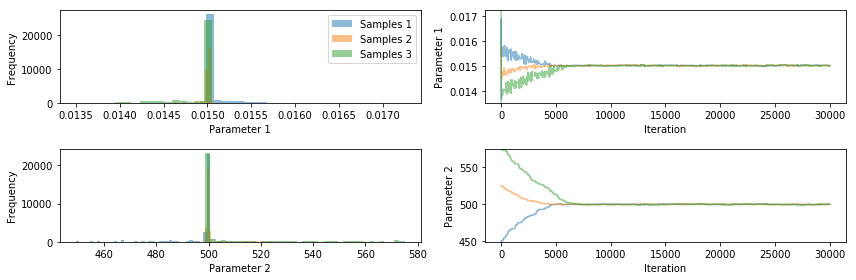

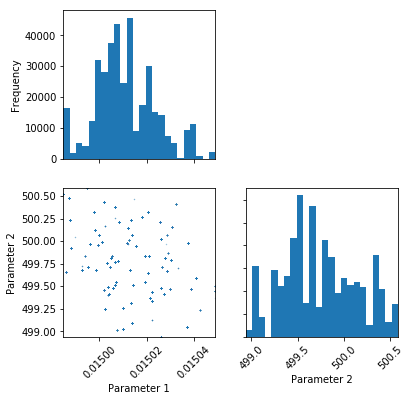

In [52]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [53]:
metropolis_chains.shape

(3, 30000, 2)

In [54]:
metropolis_chains[0][:10]

array([[1.35000000e-02, 4.50000000e+02],
       [1.69043950e-02, 4.49264909e+02],
       [1.69043950e-02, 4.49264909e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02],
       [1.54399757e-02, 4.49868675e+02]])

In [55]:
emulated_chains[0][:10]

array([[1.35000000e-02, 4.50000000e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02],
       [1.43719721e-02, 4.50290153e+02]])

In [56]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = pints.toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      7665086    0:00.0
1     2      7665086    0:00.0
2     3      7665086    0:00.0
3     4      7665086    0:00.0
20    21     7665086    0:00.0
40    41     7665086    0:00.0
60    61     7665086    0:00.0
80    81     7665086    0:00.0
100   100    7665086    0:00.0
Halting: Maximum number of iterations (100) reached.
Score at true solution: 
10134.983068980146
Found solution:          True parameters:
 1.00000000000000002e-02     1.49999999999999994e-02
 4.50000000000000000e+02     5.00000000000000000e+02


In [57]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = RescaledModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [1, 1]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)
found_parameters[0] = found_parameters[0] / 50
found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      2407624    0:00.0
1     2      1379289    0:00.0
2     3      630597     0:00.0
3     4      219339.5   0:00.0
20    21     10124.07   0:00.0
40    41     10124.06   0:00.0
60    61     10124.05   0:00.0
80    81     10124.04   0:00.0
100   100    10124.03   0:00.0
Halting: Maximum number of iterations (100) reached.
Score at true solution: 
55898501.46767806
Found solution:          True parameters:
 1.50082811106579724e-02     1.49999999999999994e-02
 4.99996709575635748e+02     5.00000000000000000e+02
